In [1]:
%load_ext autoreload
%autoreload 2

Prerequisites: make sure that the notebook can read and write to s3 bucket ```comprehend-semi-structured-docs-{REGION}-{AWS_ID}```

In [2]:
import json
import boto3

s3_client = boto3.client('s3')
s3_resource = boto3.resource("s3")

session = boto3.session.Session()
REGION = session.region_name
sts = session.client('sts')
AWS_ID = sts.get_caller_identity().get('Account')

# Creates inputs for Pre-Labeling Tool


The Pre-Labeling Tool requires 3 main inputs:
- a dataset of **PDF documents**
- 1 **expected_entities** file per pdf. This file contains the words that the tool will look for in the document to pre-annotate it.
- a **premanifest** file that maps each one of the PDF documents with its expected_entities file

This notebook will show you how to get and generate these inputs.

## Prepare a public dataset of pdf documents

In this demo we will use a dataset consisting in fake bank statements. 

The next cells will show you how to:
- Download the public dataset used for demo
- Convert the files from png into pdf format
- Upload the pdf files into your private s3 bucket

First, we download the public dataset

In [3]:
import pathlib

path_png_zipped = "data/docs/png/zipped"
path_png_unzipped = "data/docs/png/unzipped"
path_pdf = "data/docs/pdf"

pathlib.Path(path_png_zipped).mkdir(parents=True, exist_ok=True)
pathlib.Path(path_png_unzipped).mkdir(parents=True, exist_ok=True)
pathlib.Path(path_pdf).mkdir(parents=True, exist_ok=True)

In [4]:
bucket_workshop_data = 'idp-assets-wwso'
s3_key_workshop_data = 'workshop-data/classification-training.zip'

In [5]:
s3_client.download_file(
    Bucket=bucket_workshop_data, 
    Key=s3_key_workshop_data, 
    Filename=f'{path_png_zipped}/classification-training.zip'
)

Then we unzip the file

In [6]:
import zipfile

# unzip file
with zipfile.ZipFile(f'{path_png_zipped}/classification-training.zip', 'r') as zip_ref:
    zip_ref.extractall(path_png_unzipped)

In [7]:
pgn_files = ['bank_stmt_0.png','bank_stmt_1.png','bank_stmt_10.png','bank_stmt_11.png','bank_stmt_12.png']

Let's see how the files that we will use in this demo look like.

bank_stmt_0.png


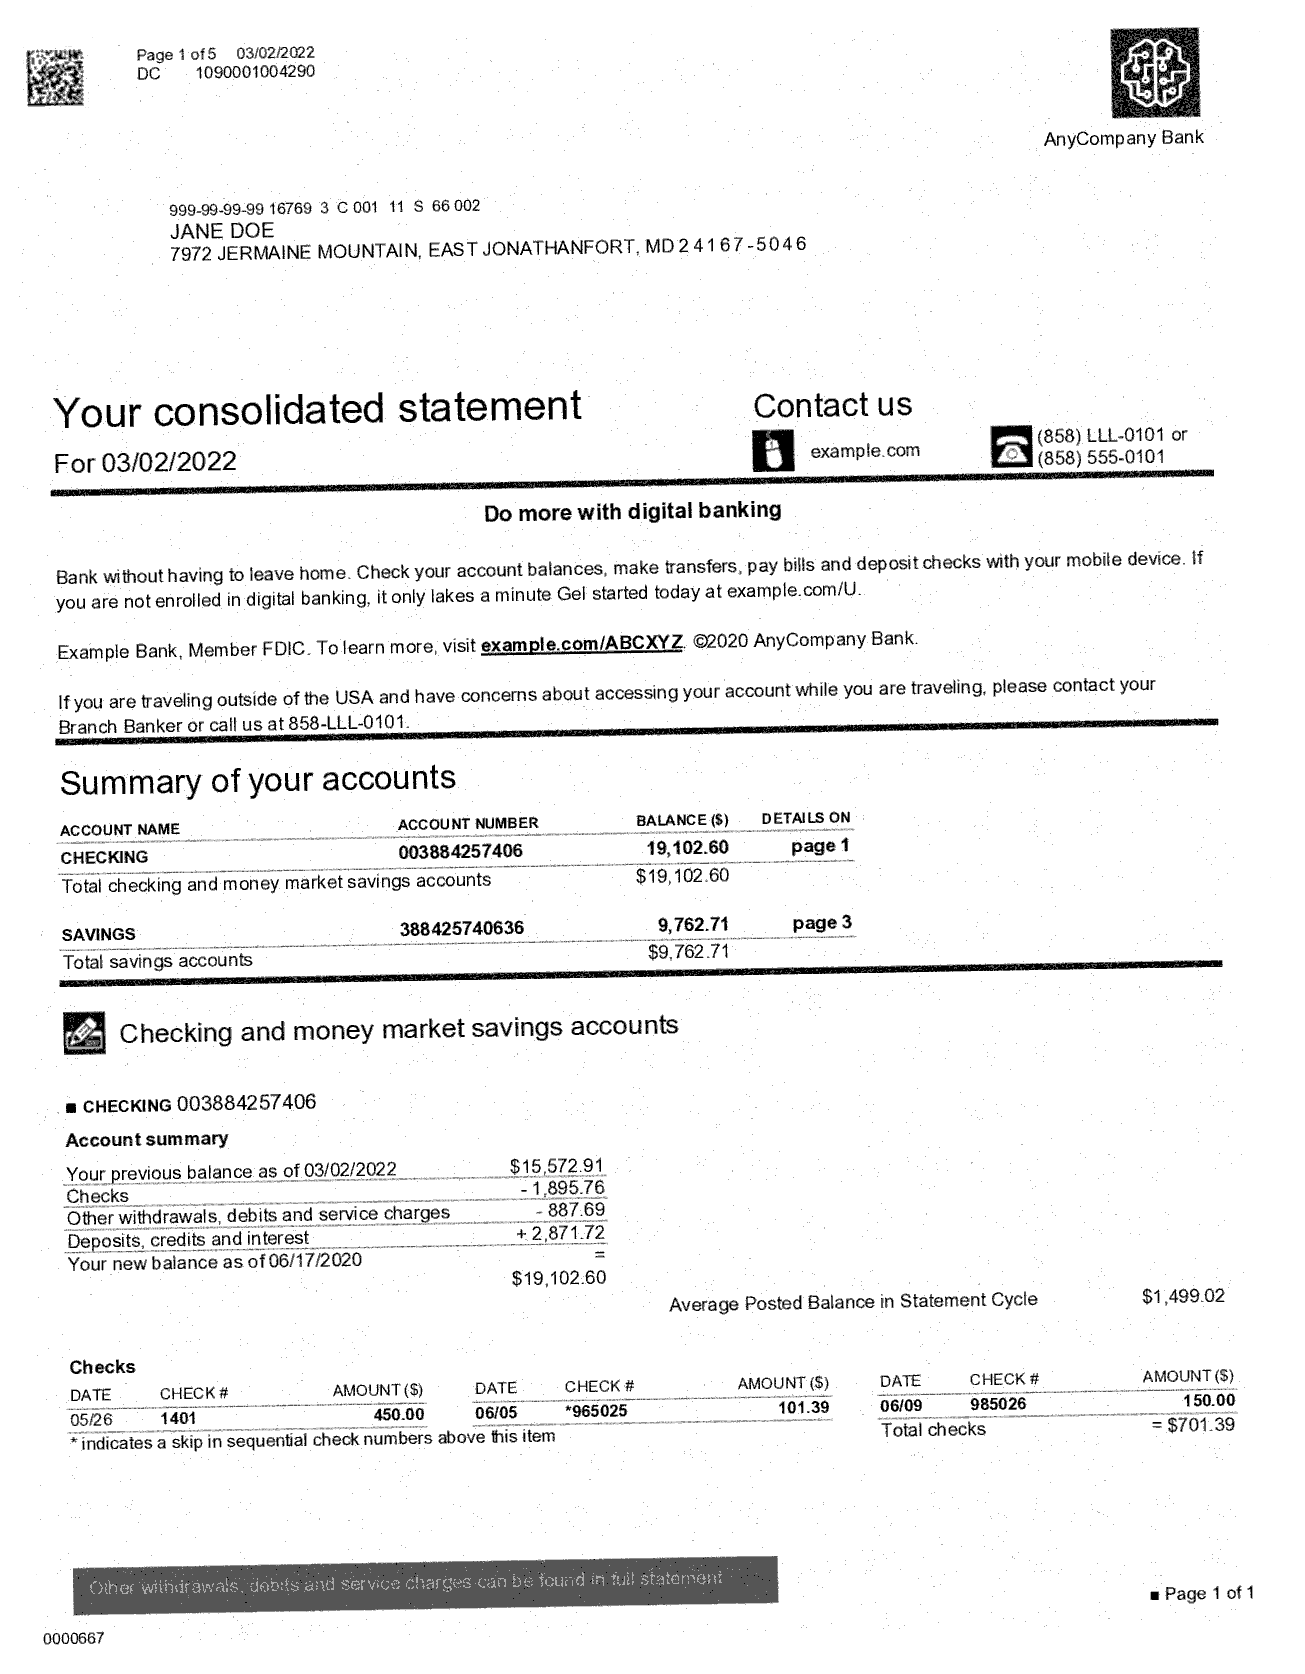

In [8]:
from PIL import Image
# Display the document
file_to_display = pgn_files[0]
print(file_to_display)
Image.open(f'{path_png_unzipped}/bank-statements/{file_to_display}')

We can now upload the PDF in s3.

**IMPORTANT NOTE**: all the inputs used by the Pre-Labeling Tool (including the PDF documents) must be placed in the bucket ```comprehend-semi-structured-docs-{region-name}-{account-id}``` that was created by the SAM template.
Indeed, the Semi-Structured Documents Annotation Tool used (cf [here](https://github.com/aws-samples/amazon-comprehend-semi-structured-documents-annotation-tools)) does not support input data outside of this bucket.

We will organize the Pre-Annotation inputs as follow in the ```comprehend-semi-structured-docs-{region-name}-{account-id}```:


```
└── comprehend-semi-structured-docs-{region-name}-{account-id}
    └── prelabeling-inputs
        └── example-demo
            ├── pdf/
            │   ├── bank_stmt_0.pdf
            │   ├── bank_stmt_1.pdf
            │   ├── bank_stmt_10.pdf
            │   ├── bank_stmt_11.pdf
            │   └── bank_stmt_12.pdf
            ├── expected-entities/
            │   ├── file_bank_stmt_0.json
            │   ├── file_bank_stmt_1.json
            │   ├── file_bank_stmt_10.json
            │   ├── file_bank_stmt_11.json
            │   └── file_bank_stmt_12.json
            └── premanifest/
                └── premanifest.json
```    

In [9]:
inputs_subfolder = 'example-demo' # subfolders where inputs will be placed

In [10]:
bucket = f'comprehend-semi-structured-docs-{REGION}-{AWS_ID}'

prelabeling_folder = 'prelabeling-inputs'

s3_folder_pdf = f'{prelabeling_folder}/{inputs_subfolder}/pdf'
s3_folder_expected_entities = f'{prelabeling_folder}/{inputs_subfolder}/expected-entities'
s3_folder_premanifest = f'{prelabeling_folder}/{inputs_subfolder}/premanifest'

In [11]:
import io


for file in pgn_files:
    # Converts png files into pdf files
    raw_file_name = file[:-4]
    image_1 = Image.open(f'{path_png_unzipped}/bank-statements/{file}')
    im_1 = image_1.convert('RGB')
    
    # Saves pdf files locally
    out_path=f'{path_pdf}/{raw_file_name}.pdf'
    im_1.save(out_path)

    s3_resource.Object(bucket, f'{s3_folder_pdf}/{raw_file_name}.pdf').upload_file(out_path)

## Create the expected_entities files and the premanifest file

Once you have collected a dataset of pdf documents, you need to collect the corresponding **expected entities** that you want to use to pre-annotate the documents. This corresponds to data that some companies have in the ERP software. 
In this example we have manually created a CSV file with all entites (expected text + entity_type) for all documents in our example dataset.

This file looks like the following:

In [12]:
import pandas as pd
all_entities = pd.read_csv('data/entities/list_expected_entities.csv')
all_entities

,file_name,entity_type,expected_text
0,bank_stmt_0.pdf,bank_name,AnyCompany Bank
1,bank_stmt_0.pdf,customer_name,JANE DOE
2,bank_stmt_0.pdf,checking_number,003884257406
3,bank_stmt_0.pdf,checking_amount,"19,102.60"
4,bank_stmt_0.pdf,savings_number,388425740636
5,bank_stmt_0.pdf,savings_amount,"9,762.71"
6,bank_stmt_1.pdf,bank_name,AnyCompany Bank
7,bank_stmt_1.pdf,customer_name,MARIA GARCIA
8,bank_stmt_1.pdf,checking_number,004582371449
9,bank_stmt_1.pdf,checking_amount,7.373.54


We will now use this ```list_expected_entities.csv``` to create the 2 inputs that are required by our Pre-Labeling tool:
- the `expected_entities` files for each PDF
- the `premanifest` file (which links each PDF document to its expected_entities file)

In [13]:
def generate_expected_entities(df):
    """
    Generates the expected_entities file content
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with the following columns: `file_name`,  `entity_type`, `expected_text`
    Returns
    ----------
    list_of_ent_dicts : list
        list of dictionaries of the expected_entities
    """
    list_of_ent_dicts=[]
    for idx,row in df.iterrows():
        entity_type=row["entity_type"]
        text=row["expected_text"]
        dict_of_ent= {
            "expected_texts":[text],
            "entity_type":entity_type,
            "ignore_list":[]
        }
        list_of_ent_dicts.append(dict_of_ent)
    return list_of_ent_dicts

In [14]:
def generate_prelabeling_inputs(all_entities, bucket: str, s3_folder_expected_entities: str, s3_folder_pdf: str, s3_folder_premanifest: str):
    """
    Saves expected_entities files and premanifest file in s3
    
    Parameters
    ----------
    all_entities : pd.DataFrame
        dataframe with the following columns: `file_name`,  `entity_type`, `expected_text`
    bucket : str
        s3 bucket name used by the Pre-Labeling Tool. Should be the bucket where inputs and outputs are saved.
    s3_folder_expected_entities : str
        s3 key to use to save the expected_entities files
    s3_folder_pdf : str
        s3 key where pdf are stored
    s3_folder_premanifest : str
        s3 key to use to save the premanifest file
        
    Returns
    -------
    list_expected_entities : List[Dict]
        list of dictionaries of the expected_entities
    lines_of_manifest : List[Dict]
        manifest file content
    """
    
    # get all file names
    pdf_file_names=list(all_entities["file_name"].unique())

    lines_of_manifest=[]

    for file_name in pdf_file_names:
        df_expected_entites_in_file=all_entities[all_entities["file_name"]==file_name]

        # Create expected_entity dict
        list_expected_entities= generate_expected_entities(df_expected_entites_in_file)
        # Saves expected_entity dict in s3
        response = s3_client.put_object(
            Body=json.dumps(list_expected_entities),
            Bucket=bucket, 
            Key=f'{s3_folder_expected_entities}/file_{file_name[:-4]}.json'
        )
        if response['ResponseMetadata']['HTTPStatusCode']!=200:
            raise

        ## Create manifest line ###
        line_dict={
            "pdf":f's3://{bucket}/{s3_folder_pdf}/{file_name}', 
            "expected_entities":f's3://{bucket}/{s3_folder_expected_entities}/file_{file_name[:-4]}.json'
        }
        lines_of_manifest.append(line_dict)

    print(f'Successfully saved {len(lines_of_manifest)} expected_entities files in {bucket}/{s3_folder_expected_entities}/')

    #Store the manifest in S3
    response = s3_client.put_object(
        Body=json.dumps(lines_of_manifest),
        Bucket=bucket,
        Key=f'{s3_folder_premanifest}/premanifest.json'
    )

    if response['ResponseMetadata']['HTTPStatusCode']==200:
        print(f'Successfully save premanifest file in {bucket}/prelabeling-inputs/premanifest.json')
    
    return list_expected_entities, lines_of_manifest

In [15]:
list_expected_entities, lines_of_manifest = generate_prelabeling_inputs(
    all_entities=all_entities,
    bucket=bucket,
    s3_folder_expected_entities=s3_folder_expected_entities,
    s3_folder_pdf=s3_folder_pdf,
    s3_folder_premanifest=s3_folder_premanifest
)

Successfully saved 5 expected_entities files in comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/expected-entities/
Successfully save premanifest file in comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/premanifest.json


Let's look at the format of these files

Each expected_entities file corresponds to a JSON file which is the list of all the entities for 1 PDF document. 

Each element of this list is an entity represented by a dict with the following keys:
- ```expected_texts```: a list of strings for a given entity. The Pre-Labeling Tool will look for each of these strings in the PDF. In case you are unsure about the precise spelling of the entity in the document, you can give give multiple strings in this list. This can be useful in the case of abbreviations for example.
- ```entity_type```: a string with the entity type. If not defined, the item will be labled with ```entity_type ="UNASSIGNED"```
- ```ignore_list``` (optional): list of words that should be ignored in the match. Because the labeling uses a fuzzy matching you might have certain matches that you know are wrong for a given entity. That can be useful to ignore some numbers or to ignore email address when looking at names.


In our case, here is an example of one of these entity_file:


In [16]:
print(json.dumps(list_expected_entities,indent=4))

[
    {
        "expected_texts": [
            "AnyCompany Finance Ltd"
        ],
        "entity_type": "bank_name",
        "ignore_list": []
    },
    {
        "expected_texts": [
            "MARTHA RIVERA"
        ],
        "entity_type": "customer_name",
        "ignore_list": []
    },
    {
        "expected_texts": [
            "005899666971"
        ],
        "entity_type": "checking_number",
        "ignore_list": []
    },
    {
        "expected_texts": [
            "16,150.77"
        ],
        "entity_type": "checking_amount",
        "ignore_list": []
    },
    {
        "expected_texts": [
            "589966697136"
        ],
        "entity_type": "savings_number",
        "ignore_list": []
    },
    {
        "expected_texts": [
            "15,391.92"
        ],
        "entity_type": "savings_amount",
        "ignore_list": []
    }
]


The premanifest must have the following format:
- one file per line
- each lines should have the following keys:
    - pdf : the s3 key of the file to be annotated
    - expected_entities : the s3 key of the file that contains the expected text # This is optional for labeling with an existing Comprehend model (cf next section)
    
This is how the premanifest file looks like in our case:

In [17]:
print(json.dumps(lines_of_manifest,indent=4))

[
    {
        "pdf": "s3://comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/pdf/bank_stmt_0.pdf",
        "expected_entities": "s3://comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/expected-entities/file_bank_stmt_0.json"
    },
    {
        "pdf": "s3://comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/pdf/bank_stmt_1.pdf",
        "expected_entities": "s3://comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/expected-entities/file_bank_stmt_1.json"
    },
    {
        "pdf": "s3://comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/pdf/bank_stmt_12.pdf",
        "expected_entities": "s3://comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo/expected-entities/file_bank_stmt_12.json"
    },
    {
        "pdf": "s3://comprehend-semi-structured-docs-e

Please note that there are 2 possible versions of the Pre-Labeling Tool:
- **Fuzzy Matching Version**: in this version, the Pre-Labeling Tool will use the expected_entities files that we just created to pre-annotate the documents.
- **Comprehend version**: for this version, the Pre-Labeling Tool will use an already existing Comprehend custom entity recognizer to pre-annotate the documents instead of the expected_entities files that we created. Hence, this option assumes that you already have already trained a Comprehend custom entity recognizer. In that case, the expected_entities files are not required as an input. Hence the ```expected_entities``` key in the premanifest file is optional. If ```expected_entities``` is provided, the entities won't be use to pre-annotate the file but will be shown as an indication for the annotators in the Ground Truth Labeling interface.

# Training a Comprehend Custom Entity Recognizer model using the Pre-Labeling Tool [OPTIONAL]

Using the Pre-Labeling Tool, you can automatically create a Ground Truth Labeling job and/or directly train a Comprehend Custom Entity Recognizer model using the pre-annotations generated.

If you want to train a Comprehend Custom Entity Recognizer model, you need at least 250 documents mapped in the manifest file (with their corresponding expected_entities files).

For the purpose of the demo, we will just duplicate the lines of the manifest file that we created to be able to showcase this option.

Please note that doing this will result in a highly overfitted model.


```
└── comprehend-semi-structured-docs-{region-name}-{account-id}
    └── prelabeling-inputs
        ├── example-demo
        └── example-demo-training
            ├── pdf
            │   ├── bank_stmt_0_duplication_0.pdf
            │   ├── ...
            │   ├── bank_stmt_0_duplication_49.pdf
            │   ├── bank_stmt_1_duplication_0.pdf
            │   ├── ...
            │   ├── bank_stmt_1_duplication_49.pdf
            │   ├── bank_stmt_10_duplication_0.pdf
            │   ├── ...
            │   ├── bank_stmt_10_duplication_49.pdf
            │   ├── bank_stmt_11_duplication_0.pdf
            │   ├── ...
            │   ├── bank_stmt_11_duplication_49.pdf            
            │   ├── bank_stmt_12_duplication_0.pdf
            │   ├── ...
            │   ├── bank_stmt_12_duplication_49.pdf
            ├── expected-entities
            │   ├── file_bank_stmt_0.json
            │   ├── file_bank_stmt_1.json
            │   ├── file_bank_stmt_10.json
            │   ├── file_bank_stmt_11.json
            │   └── file_bank_stmt_12.json
            └── premanifest
                └── premanifest.json
```    

In [18]:
inputs_subfolder_training = 'example-demo-training' # subfolders where inputs will be placed

In [19]:
import io

for file in pgn_files:
    # Converts png files into pdf files
    raw_file_name = file[:-4]
    image_1 = Image.open(f'{path_png_unzipped}/bank-statements/{file}')
    im_1 = image_1.convert('RGB')

    # Saves pdf files locally
    out_path=f'{path_pdf}/{raw_file_name}.pdf'
    im_1.save(out_path)
    for i in range(50):
        s3_resource.Object(bucket, f'{prelabeling_folder}/{inputs_subfolder_training}/pdf/{raw_file_name}_duplication_{i}.pdf').upload_file(out_path)

print('Successfully duplicated files')

Successfully duplicated files


In [20]:
file_names = list(all_entities["file_name"].unique())

newlines=[]
for ii in range(50):
    for name in file_names: 
        new_pd = all_entities[all_entities["file_name"]==name]
        new_pd["file_name"] = name[:-4]+ "_duplication_" + str(ii) +".pdf"
        newlines.append(new_pd)
    
new_file = pd.concat(newlines)

new_file.to_csv("data/entities/list_expected_entities_500.csv", index=False)

/tmp/ipykernel_7499/4268431819.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_pd["file_name"] = name[:-4]+ "_duplication_" + str(ii) +".pdf"


In [21]:
all_entities_500 = pd.read_csv('data/entities/list_expected_entities_500.csv')

In [22]:
_list_expected_entities, _lines_of_manifest = generate_prelabeling_inputs(
    all_entities=all_entities_500,
    bucket=bucket,
    s3_folder_expected_entities=f'{prelabeling_folder}/{inputs_subfolder_training}/expected-entities',
    s3_folder_pdf=f'{prelabeling_folder}/{inputs_subfolder_training}/pdf',
    s3_folder_premanifest=f'{prelabeling_folder}/{inputs_subfolder_training}/premanifest'
)

Successfully saved 250 expected_entities files in comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/example-demo-training/expected-entities/
Successfully save premanifest file in comprehend-semi-structured-docs-eu-central-1-941617455917/prelabeling-inputs/premanifest.json


We now have everything we need for using the Pre-Labeling Tool! You can start the tool by using the notebook [start_step_functions.ipynb](labeling-tool/Pre_labeling_tool/notebooks/start_step_functions.ipynb)